In [1]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pint
from pint import UnitRegistry

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
def to_CI(df):
    def celc(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degC)
        return home.to('degK')

    def ream(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degR)
        return home.to('degK')
    
    celc_features = ['ZT1AB', 'ZTNAC', 'ZTOIL', 'ZT1A', 'GEGTMC', 'ZTNAC_D']
    ream_features = ['ZTAMB']
    
    for cl in celc_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(celc(df[cl].values))
            
    for cl in ream_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(ream(df[cl].values))
    
    return df

def preprocess_file(df, corr_ther, targets):
    def delete_corr(df, ther):
        was_corr = []
        corr = df.corr()
        for row in corr.iterrows():
            for v_ind in range(len(row[1])):
                if row[1][v_ind] > ther and row[1][v_ind] < 1: #ПЕРЕСЧИТАТЬ
                    if (row[0] not in was_corr) and (row[1].index[v_ind] not in was_corr):
                        print(row[0], row[1].index[v_ind], row[1][v_ind])
                        was_corr.append(row[0])
        print(len(was_corr))
        return was_corr
    #удалить лишние
    df = df.drop(['flight_datetime', 'engine_id'], axis = 1)
    
    #виды фичей
    to_categorical = ['IAIE','IBE','IBP','IAI','BRAT','engine_type','n1_modifier',
                  'IVS12','number_blades','engine_position','engine_family', 'manufacturer',
                  'aircraft_family','aircraft_type','aircraft_grp','ac_manufacturer']
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #убрать те у которых больше 2/3 пропущены значения
    for cl in numerical:
        if (cl in df.columns.to_list()) and (len(df[cl]) * 2 / 3 < df[cl].isna().sum()):
            df = df.drop([cl], axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    #заполнить оставшиеся пропуски нулями
    df = df.fillna(0)
    
    #перевести в систему СИ
    df = to_CI(df)

    #убрать скоррелированные фичи
    was_corr = delete_corr(df[numerical], corr_ther)
    print('КОРРЕЛЯЦИЯ', was_corr)
    df.drop(was_corr, axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #скалировать данные
    scaled_features = StandardScaler().fit_transform(df[numerical].values)
    scaled_features_df = pd.DataFrame(scaled_features, index=df[numerical].index, columns=df[numerical].columns)
    
    scaled_features_df
    #исправить типы данных категориальных фичей
    for cl in to_categorical:
        if cl in df.columns.to_list():
            df[cl] = df[cl].astype(object)
            #One Hot Encoding
            one_hot = pd.get_dummies(df[cl])
            scaled_features_df = pd.concat([scaled_features_df,one_hot], axis=1)
    
    scaled_features_df = pd.concat([scaled_features_df,df[targets]], axis=1)
    
    return scaled_features_df

In [17]:
df = pd.read_csv("../data/grouped/takeoff_CF34-8E.csv")
df.columns

Index(['engine_id', 'flight_datetime', 'engine_position', 'n1_modifier',
       'number_blades', 'engine_type', 'manufacturer', 'ZPCN12', 'ZPCN25',
       'ZPN12R', 'ZPOIL', 'ZPS3', 'ZT1AB', 'ZT3', 'ZT49', 'ZTAMB', 'ZTLA',
       'ZTOIL', 'ZVB1F', 'ZVB2R', 'ZVSV', 'ZWF36', 'IHPSOV', 'aircraft_family',
       'aircraft_type', 'aircraft_grp', 'ac_manufacturer', 'IAI', 'ZALT',
       'ZT1A', 'ZVIAS', 'ZWBP1_8E', 'ZWBP2_8E', 'ZXM', 'IBE', 'IBP', 'IAIE',
       'BRAT', 'DELFN', 'DELN1', 'EGTHDM', 'EGTHDM_D', 'PCN12', 'PCN1K',
       'SLOATL', 'SLOATL_D', 'ZPCN25_D', 'ZT49_D', 'ZWF36_D'],
      dtype='object')

In [303]:
def to_CI(df):
    def celc(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degC)
        return home.to('degK')

    def ream(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degR)
        return home.to('degK')
    
    celc_features = ['ZT1AB', 'ZTNAC', 'ZTOIL', 'ZT1A', 'GEGTMC', 'ZTNAC_D']
    ream_features = ['ZTAMB']
    
    for cl in celc_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(celc(df[cl].values))
            
    for cl in ream_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(ream(df[cl].values))
    
    return df

def preprocess_file(df, corr_ther, targets):
    def delete_corr(df, ther):
        was_corr = []
        corr = df.corr()
        for row in corr.iterrows():
            for v_ind in range(len(row[1])):
                if row[1][v_ind] > ther and row[1][v_ind] < 1: #ПЕРЕСЧИТАТЬ
                    if (row[0] not in was_corr) and (row[1].index[v_ind] not in was_corr):
                        was_corr.append(row[0])
        return was_corr
    #удалить лишние
    df = df.drop(['flight_datetime', 'engine_id'], axis = 1)
    
    #виды фичей
    to_categorical = ['IAIE','IBE','IBP','IAI','BRAT','engine_type','n1_modifier',
                         'IVS12','number_blades','engine_position','engine_family', 'manufacturer',
                         'aircraft_family','aircraft_type','aircraft_grp','ac_manufacturer']
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #убрать те у которых больше 2/3 пропущены значения
    for cl in numerical:
        if (cl in df.columns.to_list()) and (len(df[cl]) * 2 / 3 < df[cl].isna().sum()):
            df = df.drop([cl], axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    #заполнить оставшиеся пропуски нулями
    df = df.fillna(0)
    
    #перевести в систему СИ
    df = to_CI(df)

    #убрать скоррелированные фичи
    was_corr = delete_corr(df[numerical], corr_ther)
    df.drop(was_corr, axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #скалировать данные
    scaled_features_df = df[numerical]
#     scaled_features = StandardScaler().fit_transform(df[numerical])
#     scaled_features_df = pd.DataFrame(scaled_features, index=df[numerical].index, columns=df[numerical].columns)
    
    #исправить типы данных категориальных фичей
    for cl in to_categorical:
        if cl in df.columns.to_list():
            df[cl] = df[cl].astype(str)
            #One Hot Encoding
            one_hot = pd.get_dummies(df[cl],prefix = cl)
            scaled_features_df = pd.concat([scaled_features_df,one_hot], axis=1)
    
    scaled_features_df = pd.concat([scaled_features_df,df[targets]], axis=1)
    
    return scaled_features_df

In [304]:
df = pd.read_csv("../data/grouped/takeoff_CFM56-7.csv")       
targets = ['DELFN',
 'DELN1',
 'EGTHDM',
 'EGTHDM_D',
 'PCN12',
 'PCN12I',
 'PCN1AR',
 'PCN1BR',
 'PCN1K',
 'SLOATL',
 'SLOATL_D',
 'ZPCN25_D',
 'ZT49_D']

to_categorical = ['IAIE','IBE','IBP','IAI','BRAT','engine_type','n1_modifier',
                         'IVS12','number_blades','engine_position','engine_family', 'manufacturer',
                         'aircraft_family','aircraft_type','aircraft_grp','ac_manufacturer']

numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))

df = preprocess_file(df, 0.95, targets)

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


In [305]:
# Целевые переменные

y = pd.read_csv("../data/y.csv")
targets = y.columns.to_list()
tr = ["engine_id", "flight_datetime", "flight_phase"]
for t in tr:
    targets.remove(t)

tr = deepcopy(targets)
for t in tr:
    if t not in df.columns.to_list():
        targets.remove(t)
        
features = list(set(df.columns.to_list()) - set(targets))

In [306]:
targets

['DELFN',
 'DELN1',
 'EGTHDM',
 'EGTHDM_D',
 'PCN12',
 'PCN12I',
 'PCN1AR',
 'PCN1BR',
 'PCN1K',
 'SLOATL',
 'SLOATL_D',
 'ZPCN25_D',
 'ZT49_D']

In [307]:
#не учить категориальные фичи

if 'WBI' in targets:
    targets.remove('WBI')
    
if 'BRAT' in targets:
    targets.remove('BRAT')

### Train test

In [308]:
X = df[features].values
y = df[targets].values
#y = y.reshape(y.shape[0], 1)

In [309]:
df[features].head()

,ac_manufacturer_BOEING,manufacturer_CFM INTERNATIONAL,CAS,engine_type_CFM56-7B26,IAIE_0.0,engine_type_CFM56-7B27/B1,n1_modifier_4.0,IBP_1.0,ZVB2F,IAI_0.0,...,aircraft_type_B737-800,ZXM,ZVB2R,IAIE_1.0,IBP_0.0,n1_modifier_3.0,BRAT_0.5,AGW,ZVB1F,engine_position_2
0,1,1,179.029999,1,1,0,0,1,0.11,1,...,1,0.2753,0.07,0,0,0,0,74.403000,0.560,1
1,1,1,190.440002,1,0,0,0,1,0.06,1,...,1,0.2927,0.02,1,0,0,0,68.306999,0.211,1
2,1,1,186.410004,1,1,0,0,1,0.08,1,...,1,0.2893,0.05,0,0,0,0,71.758003,0.180,1
3,1,1,206.309998,1,1,0,0,1,0.05,1,...,1,0.3218,0.02,0,0,0,0,65.376000,0.480,0
4,1,1,177.940002,1,1,0,0,1,0.03,1,...,1,0.2755,0.03,0,0,1,0,66.419998,0.180,0


In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [311]:
from catboost import CatBoostRegressor

In [312]:
from lightgbm import LGBMRegressor

In [313]:
model = CatBoostRegressor(learning_rate=1,
                          depth=10,
                          n_estimators=30,
                          loss_function='MultiRMSE')

#model = LGBMRegressor()

# Fit model
model.fit(X_train, y_train)
# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print('train rmse', round(train_metric_rmse, 3))
print('test rmse', round(test_metric_rmse, 3))

0:	learn: 16.6450788	total: 157ms	remaining: 4.56s
1:	learn: 14.0928815	total: 316ms	remaining: 4.43s
2:	learn: 12.5714684	total: 488ms	remaining: 4.39s
3:	learn: 11.4573617	total: 644ms	remaining: 4.18s
4:	learn: 11.1589440	total: 807ms	remaining: 4.04s
5:	learn: 10.3410647	total: 977ms	remaining: 3.91s
6:	learn: 9.8187311	total: 1.14s	remaining: 3.76s
7:	learn: 9.2345980	total: 1.32s	remaining: 3.62s
8:	learn: 8.7403584	total: 1.49s	remaining: 3.49s
9:	learn: 8.2191178	total: 1.65s	remaining: 3.3s
10:	learn: 7.8880282	total: 1.81s	remaining: 3.13s
11:	learn: 7.6942322	total: 1.99s	remaining: 2.99s
12:	learn: 7.4816612	total: 2.16s	remaining: 2.83s
13:	learn: 7.2707824	total: 2.33s	remaining: 2.66s
14:	learn: 7.0224427	total: 2.52s	remaining: 2.52s
15:	learn: 6.8430274	total: 2.71s	remaining: 2.37s
16:	learn: 6.6767878	total: 2.89s	remaining: 2.21s
17:	learn: 6.4368999	total: 3.05s	remaining: 2.04s
18:	learn: 6.2103434	total: 3.24s	remaining: 1.88s
19:	learn: 6.0642410	total: 3.4s	rem

In [213]:
class MyDataset:
    def __init__(self, features, targets):
        self.features = features
        self.labels = targets

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feat_ = torch.tensor(self.features[idx], dtype=torch.float)
        label_ = torch.tensor(self.labels[idx], dtype=torch.float)
        
        return feat_, label_

In [214]:
training_set = MyDataset(X_train, y_train)
training_loader = torch.utils.data.DataLoader(training_set, batch_size = 32)

val_set = MyDataset(X_test, y_test)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32)

### Модель

In [215]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layer1=nn.Linear(X_train.shape[1], X_train.shape[1] * 3)
        self.layer2=nn.Linear(X_train.shape[1] * 3, X_train.shape[1] * 2)
        self.layer3=nn.Linear(X_train.shape[1] * 2, X_train.shape[1] // 2)
        self.layer4=nn.Linear(X_train.shape[1] // 2, y_train.shape[1])
        
    def forward(self,x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        x=F.relu(self.layer3(x))
        x=self.layer4(x)
        return x       

### Clearml

In [201]:
# %env CLEARML_WEB_HOST=https://app.clear.ml
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# # sky_rulers
# %env CLEARML_API_ACCESS_KEY=IQQHDZCO8XLA0RMX39VS
# %env CLEARML_API_SECRET_KEY=OjHNVcteg8ISHdMiEYjkNbShaFqfEk8fvQctlM7DcjffAWOFlr

In [202]:
# from clearml import Task
# task = Task.init(project_name='SkyRulers',
#                  task_name='LinearModel_30ep_takeoff_CFM56-7')

In [216]:
model = NN()

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

In [217]:
epochs=60
history = []

for i in range(epochs):
    loss_sum = 0
    loss_count = 0
    for x_batch, y_batch in training_loader:
        #initialize the model parameter
        optimizer.zero_grad()
        #calculate the loss
        output = model.forward(x_batch)
        loss = loss_fn(output, y_batch)
        loss_sum += math.sqrt(loss.detach().numpy())
        loss_count += 1
        #backpropagation
        loss.backward()
        #update the parameters
        optimizer.step()
    if(i % 5 == 0):
        print(f"epochs: {i}......loss:{loss_sum / loss_count}")
    history.append(loss_sum / loss_count)

epochs: 0......loss:62.45212237013748
epochs: 5......loss:8.045746694820922
epochs: 10......loss:6.828204927073586
epochs: 15......loss:6.180946926350374
epochs: 20......loss:6.1486354891837625
epochs: 25......loss:6.363007412362952
epochs: 30......loss:6.46258040950082
epochs: 35......loss:6.446039678863407
epochs: 40......loss:6.444633444421945
epochs: 45......loss:6.444408949815528
epochs: 50......loss:6.444355107200327
epochs: 55......loss:6.444334784181476


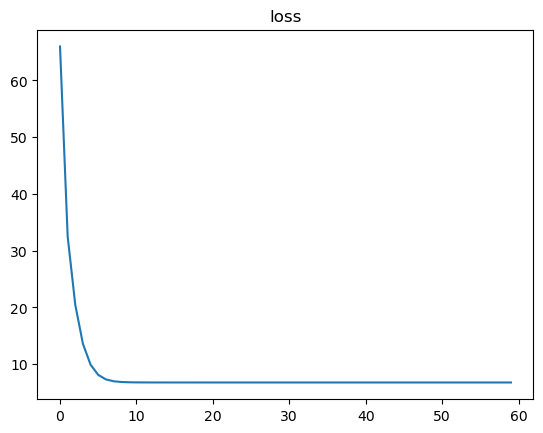

In [129]:
plt.plot(history)
plt.title('loss')
plt.show()

In [79]:
y_train_pred = model(torch.tensor(X_train,dtype=torch.float))
y_test_pred = model(torch.tensor(X_test,dtype=torch.float))

#convert to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()

In [80]:
test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print('train rmse', round(train_metric_rmse, 3))
print('test rmse', round(test_metric_rmse, 3))

train rmse 0.337
test rmse 0.388


In [81]:
test_metric_r2_score = r2_score(y_test, y_test_pred)
train_metric_r2_score = r2_score(y_train, y_train_pred)
print('train r2_score', round(train_metric_r2_score, 3))
print('test r2_score', round(train_metric_r2_score, 3))

train r2_score 0.891
test r2_score 0.891


In [343]:
task_params = {'epoches': 50, 'batch_size': 32, 'test_rmse' : test_metric_rmse, 'train_rmse' : train_metric_rmse,
               'test_r2_score' : test_metric_r2_score, 'train_r2_score' : train_metric_r2_score}

task_params = task.connect(task_params)

In [82]:
torch.save(model.state_dict(), '../models/takeoff_CFM56-7.pt')

In [345]:
task.close()

In [ ]:
for filename in os.listdir("../data/grouped/"):
    if (".csv" in filename):
        df = pd.read_csv("../data/grouped/" + filename)       
        to_categorical = ['number_blades', 'engine_position', 'engine_type', 
                          'manufacturer', 'aircraft_family', 'aircraft_type', 'aircraft_grp',
                          'ac_manufacturer', 'n1_modifier', 'IAI', 'ZVB2F', 'ZVB2R', 'IBE', 'IVS12', 'IAIE']
        numerical = list(set(df.columns.to_list()) - set(to_categorical))
        df = preprocess_file(df, corr_ther = 0.95)
        
        for cl in targets:
            X = df[features].values
            y = df[cl].values
            y = y.reshape(y.shape[0], 1)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            training_set = MyDataset(X_train, y_train)
            training_loader = torch.utils.data.DataLoader(training_set, batch_size = 32)
            val_set = MyDataset(X_test, y_test)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32)
            
            task = Task.init(project_name='SkyRulers',
                 task_name=f'LinearModel_30ep_{filename + '_' + cl}')
            
                model = NN()
                optimizer = optim.SGD(model.parameters(), lr=1e-2)
                loss_fn = nn.MSELoss()
                epochs=40
                history = []

                for i in range(epochs):
                    loss_sum = 0
                    loss_count = 0
                    for x_batch, y_batch in training_loader:
                        #initialize the model parameter
                        optimizer.zero_grad()
                        #calculate the loss
                        output = model.forward(x_batch)
                        loss = loss_fn(output, y_batch)
                        loss_sum += math.sqrt(loss.detach().numpy())
                        loss_count += 1
                        #backpropagation
                        loss.backward()
                        #update the parameters
                        optimizer.step()
                    if(i % 10 == 0):
                        print(f"epochs: {i}......loss:{loss_sum / loss_count}")
                    history.append(loss_sum / loss_count)
                    
                    plt.plot(history)
                    plt.title('loss')
                    plt.show()
                    
                    y_train_pred = model(torch.tensor(X_train,dtype=torch.float))
                    y_test_pred = model(torch.tensor(X_test,dtype=torch.float))
                    #convert to numpy array
                    y_train_pred = y_train_pred.detach().numpy()
                    y_test_pred = y_test_pred.detach().numpy()
                    
                    test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
                    train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
                    
                    test_metric_r2_score = r2_score(y_test, y_test_pred)
                    train_metric_r2_score = r2_score(y_train, y_train_pred)
                    
                    task_params = {'epoches': 50, 'batch_size': 32, 'test_rmse' : test_metric_rmse, 'train_rmse' : train_metric_rmse,
                       'test_r2_score' : test_metric_r2_score, 'train_r2_score' : train_metric_r2_score}
                    task_params = task.connect(task_params)
                    torch.save(model.state_dict(), f'../models/{filename + '_' + cl}.pt')
                    task.close()